In [1]:
import numpy as np
from numpy import float32
import warnings
import os
import sys
import glob
import tensorflow as tf
import cv2
from sklearn import utils
from sklearn import preprocessing
import matplotlib.pyplot as plt
import shutil
from pathlib import Path

from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import *
from tensorflow.keras.utils import *
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

sys.path.append(os.path.join(Path.cwd(), 'utils'))
sys.path.append(os.path.join(Path.cwd(), 'data_generators'))
sys.path.append(os.path.join(Path.cwd(), 'models'))

from utils.im_utils import *
from utils.data_augmentation import *

from data_generators.PairAllClassGen import *
from data_generators.FullImageAllClassGen import *

from models.bidirectional_convlstm_model import *
from models.pair_convlstm_model import *

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
FLARE_CLASS = 'ALL'

LSTM_CHECKPOINTS_DIR = './checkpoints/lstm_checkpoints'
RESNET_CHECKPOINTS_DIR = './checkpoints/resnet_checkpoints'

# AUG_TRAIN_DATA_DIR = f'./data/{FLARE_CLASS}_data_augmented/train'
# AUG_VAL_DATA_DIR = f'./data/{FLARE_CLASS}_data_augmented/val'
# AUG_TEST_DATA_DIR = f'./data/{FLARE_CLASS}_data_augmented/test'

TRAIN_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_data_extended/train'
VAL_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_data_extended/val'
TEST_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_data_extended/test'

AUG_TRAIN_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_data_extended_augmented/train'
AUG_VAL_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_data_extended_augmented/val'
AUG_TEST_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_data_extended_augmented/test'

AUG_PAIR_TRAIN_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_data_augmented_pair/train'
AUG_PAIR_VAL_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_data_augmented_pair/val'
AUG_PAIR_TEST_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_data_augmented_pair/test'

AUG_END_PAIR_TRAIN_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_end_data_augmented_pair/train'
AUG_END_PAIR_VAL_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_end_data_augmented_pair/val'
AUG_END_PAIR_TEST_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_end_data_augmented_pair/test'

AUG_ALL_CLASS_TRAIN_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_data_augmented/train'
AUG_ALL_CLASS_VAL_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_data_augmented/val'

AUG_ALL_CLASS_PRIOR_TRAIN_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_data_augmented_prior/train/'
AUG_ALL_CLASS_PRIOR_VAL_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_data_augmented_prior/val/'

# DATA_FEATURES_DIR = './data/data_features_simple'
# DATA_FEATURES_TRAIN_DIR = './data/data_features_simple/train'
# DATA_FEATURES_VAL_DIR = './data/data_features_simple/val'
# DATA_FEATURES_TEST_DIR = './data/data_features_simple/test'

LSTM_ALL_CLASS_PRIOR_DATA_DIR = f'./new_data/{FLARE_CLASS}_lstm_data_prior'
LSTM_ALL_CLASS_DURING_DATA_DIR = f'./new_data/{FLARE_CLASS}_lstm_data_during'

In [4]:
def delete_files(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [5]:
def GetDataFolders(train_data_dir, val_data_dir, test_data_dir):
    train_folders = []
    for subdir, dirs, files in os.walk(train_data_dir):
        for d in dirs:
            if d != 'positive' and d != 'negative' and d != '.ipynb_checkpoints':
                train_folders.append(os.path.join(subdir, d))
    train_folders = np.array(train_folders)

    val_folders = []
    for subdir, dirs, files in os.walk(val_data_dir):
         for d in dirs:
                if d != 'positive' and d != 'negative' and d != '.ipynb_checkpoints':
                    val_folders.append(os.path.join(subdir, d))
    val_folders = np.array(val_folders)

    test_folders = []
    for subdir, dirs, files in os.walk(test_data_dir):
         for d in dirs:
                if d != 'positive' and d != 'negative' and d != '.ipynb_checkpoints':
                    test_folders.append(os.path.join(subdir, d))
    test_folders = np.array(test_folders)
    
    return train_folders, val_folders, test_folders

In [6]:
def GetPairDataFolders(train_data_dir, val_data_dir):
    train_folders = set()
    for subdir, dirs, files in os.walk(train_data_dir):
        for f in files:
            flare_class = os.path.join(subdir, f).rsplit('/')[-5]
            if flare_class == 'C':
                continue
            file_parent_path = os.path.join(subdir, f).rsplit('/', 2)[0]
            train_folders.add(file_parent_path)

    val_folders = set()
    for subdir, dirs, files in os.walk(val_data_dir):
        for f in files:
            flare_class = os.path.join(subdir, f).rsplit('/')[-5]
            if flare_class == 'C':
                continue
            file_parent_path = os.path.join(subdir, f).rsplit('/', 2)[0]
            val_folders.add(file_parent_path)
    
    return list(train_folders), list(val_folders)

In [7]:
def get_labels(generator, feature_extractor):
    labels = []

    for sample in generator:
        new_batch = []
        batch = sample[1]
        labels.append(batch)

    labels = np.array(labels)
    labels = labels.reshape(labels.shape[0]*labels.shape[1], labels.shape[2])
    
    return labels

In [8]:
batch_size=32
train_dir = os.path.join(LSTM_ALL_CLASS_DURING_DATA_DIR, 'train')
val_dir = os.path.join(LSTM_ALL_CLASS_DURING_DATA_DIR, 'val')
train_folders, val_folders = GetPairDataFolders(train_dir, val_dir)
traingen = PairAllClassGen(train_folders[:len(train_folders)//1], batch_size=batch_size, image_size=64)
valgen = PairAllClassGen(val_folders, batch_size=batch_size, image_size=64)

In [9]:
model = PairConvLSTMModel(batch_size, 64, 10, num_classes=3)

(None, 10, 64, 64, 1)
(None, 5, 64, 64, 1)
(None, 5, 64, 64, 1)
(None, 5, 64, 64, 1)


2022-08-26 22:21:57.562313: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 22:21:57.576317: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 22:21:57.577111: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 22:21:57.578156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

(None, 5, 64, 64, 1)


In [10]:
adam_fine = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, decay=0.0002, amsgrad=False)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate=1e-3,
decay_steps=10000,
decay_rate=0.9)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
model.compile(
    loss="categorical_crossentropy", optimizer=adam_fine, metrics=["accuracy"]
)

In [ ]:
epochs=10
history = model.fit(traingen, validation_data=valgen, epochs=epochs)

Epoch 1/10


2022-08-26 22:22:18.400080: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-26 22:22:18.840665: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-26 22:22:18.841381: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-26 22:22:18.841437: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-08-26 22:22:18.842056: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-26 22:22:18.842135: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-08-26 22:22:19.678444: I tensorflow/stream_executor/cuda/c

  8/717 [..............................] - ETA: 18:21 - loss: 12.3177 - accuracy: 0.3477

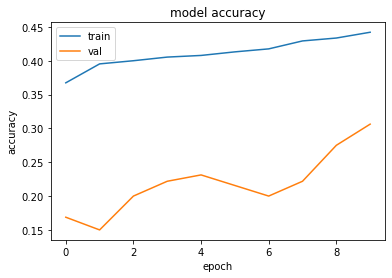

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

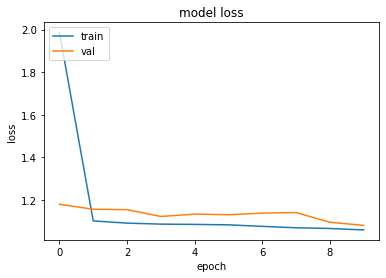

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
model.save_weights(f'{LSTM_CHECKPOINTS_DIR}/cutout_image_preflare_bidirectional_convlstm')

In [74]:
val_y = [valgen[x][1] for x in range(len(valgen))]
val_y = np.array(val_y)
val_y = np.concatenate(val_y)

In [75]:
predictions = model.predict(valgen)
true_vals = val_y

correct = 0
for idx, pred in enumerate(predictions):
    pred_round = 0
    if pred >= 0.5:
        pred_round = 1
    if pred_round == true_vals[idx]:
        correct += 1

print(f'accuracy: {correct/(len(true_vals))}')

9/9 [==============================] - 4s 268ms/step
accuracy: 0.9392361111111112


In [27]:
model = CustomLSTMPairAlexNet(batch_size, feature_extractor)

NameError: name 'feature_extractor' is not defined

In [55]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

adam_fine = Adam(learning_rate=1e-6, beta_1=0.9, beta_2=0.999, decay=0.0002, amsgrad=False)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
epochs=100

In [56]:
history = model.fit(traingen, validation_data=valgen, epochs=epochs)

Epoch 1/100
175/175 [==============================] - 70s 341ms/step - loss: 0.6970 - accuracy: 0.5004 - val_loss: 0.6975 - val_accuracy: 0.4688
Epoch 2/100
175/175 [==============================] - 54s 308ms/step - loss: 0.6961 - accuracy: 0.4962 - val_loss: 0.6956 - val_accuracy: 0.4969
Epoch 3/100
175/175 [==============================] - 54s 310ms/step - loss: 0.6943 - accuracy: 0.5048 - val_loss: 0.6945 - val_accuracy: 0.5094
Epoch 4/100
175/175 [==============================] - 54s 307ms/step - loss: 0.6947 - accuracy: 0.5008 - val_loss: 0.6939 - val_accuracy: 0.4844
Epoch 5/100
175/175 [==============================] - 54s 307ms/step - loss: 0.6942 - accuracy: 0.4949 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 6/100
175/175 [==============================] - 54s 307ms/step - loss: 0.6946 - accuracy: 0.4949 - val_loss: 0.6930 - val_accuracy: 0.5063
Epoch 7/100
175/175 [==============================] - 54s 307ms/step - loss: 0.6940 - accuracy: 0.5034 - val_loss: 0.6941 -

In [107]:
# feature_extractor = CustomResNet50(include_top=False)
# feature_extractor.load_weights(f'{RESNET_CHECKPOINTS_DIR}/sgd_newdata_B_class_1e-3_checkpoint')

In [108]:
# epochs = 20
# batch_size = 128

In [109]:
# train_folders, val_folders, test_folders = GetDataFolders(AUG_TRAIN_DATA_DIR, AUG_VAL_DATA_DIR, AUG_TEST_DATA_DIR)
# save_data_features(train_folders, feature_extractor)
# save_data_features(val_folders, feature_extractor)

In [110]:
# train_features, val_features, test_features = GetDataFolders(DATA_FEATURES_TRAIN_DIR, DATA_FEATURES_VAL_DIR, DATA_FEATURES_TEST_DIR)

In [111]:
# traingen = CustomDataFeaturesGen(train_features, batch_size)
# valgen = CustomDataFeaturesGen(val_features, batch_size)

In [112]:
feature_extractor = get_simple_conv_model(include_top=False)
feature_extractor.load_weights(f'{RESNET_CHECKPOINTS_DIR}/simple_conv_relu')

In [113]:
# train_folders, val_folders, test_folders = GetDataFolders(AUG_TRAIN_DATA_DIR, AUG_VAL_DATA_DIR, AUG_TEST_DATA_DIR)
# save_data_features(train_folders, feature_extractor)
# save_data_features(val_folders, feature_extractor)

In [114]:
def get_sequence_model_test():
    frame_features_input = keras.Input((6, 2048))

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(1, activation="sigmoid")(x)

    rnn_model = keras.Model([frame_features_input], output)
    adam_fine = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0002, amsgrad=False)
    rnn_model.compile(
        loss="binary_crossentropy", optimizer=adam_fine, metrics=["accuracy"]
    )
    return rnn_model

In [153]:
def get_sequence_model_test3(fe):
    inp = Input(shape=(20, 64, 64, 1))
    x = tf.keras.layers.TimeDistributed(fe)(inp)
    x = tf.keras.layers.TimeDistributed(GlobalAveragePooling2D())(x)
    # x = tf.keras.layers.TimeDistributed(Flatten)(x)
    x = Dense(128, activation='relu')(x)
    x = LSTM(128, dropout=0.1, return_sequences=True)(x)
    x = LSTM(64, dropout=0.1)(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(inp, x)
    adam_fine = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
    model.compile(
        loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"]
    )
    
    return model

In [154]:
epochs = 300
batch_size = 64

In [155]:
train_features, val_features, test_features = GetDataFolders(TRAIN_DATA_DIR, VAL_DATA_DIR, TEST_DATA_DIR)
traingen = CustomDataGen(train_features, batch_size)
valgen = CustomDataGen(val_features, batch_size)
testgen = CustomDataGen(test_features, batch_size)

In [156]:
model = get_sequence_model_test3(feature_extractor)
model.summary()
# history = model.fit(traingen, validation_data=valgen, epochs=epochs)

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 20, 64, 64, 1)]   0         
                                                                 
 time_distributed_22 (TimeDi  (None, 20, 19, 19, 12)   14148     
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 20, 12)           0         
 stributed)                                                      
                                                                 
 dense_18 (Dense)            (None, 20, 128)           1664      
                                                                 
 lstm_18 (LSTM)              (None, 20, 128)           131584    
                                                                 
 lstm_19 (LSTM)              (None, 64)                494

In [31]:
predictions = model.predict(valgen[1][0])
true_vals = valgen[1][1]

correct = 0
tot_neg = 0
tot_pos = 0
for idx, pred in enumerate(predictions):
    pred_round = 0
    if pred >= 0.5:
        pred_round = 1
    if pred_round == true_vals[idx]:
        correct += 1
    if true_vals[idx] == 0:
        tot_neg += 1
    elif true_vals[idx] == 1:
        tot_pos += 1

print(f'accuracy: {correct/(len(true_vals))}')
print(f'pos/neg - {tot_pos}/{tot_neg}')

3/3 [==============================] - 0s 13ms/step
accuracy: 0.6153846153846154
pos/neg - 40/38


In [29]:
predictions

array([[0.5467096 ],
       [0.8862514 ],
       [0.13409987],
       [0.59277105],
       [0.863041  ],
       [0.6344432 ],
       [0.9966635 ],
       [0.9937004 ],
       [0.88580614],
       [0.6013978 ],
       [0.23334917],
       [0.2557678 ],
       [0.21347828],
       [0.1607935 ],
       [0.6273167 ],
       [0.5301124 ],
       [0.4377179 ],
       [0.57236296],
       [0.3340299 ],
       [0.49205497],
       [0.99559975],
       [0.27208722],
       [0.63475055],
       [0.9440781 ],
       [0.99653566],
       [0.42937624],
       [0.44375506],
       [0.78722227],
       [0.99792284],
       [0.43750167],
       [0.10135993],
       [0.9414744 ],
       [0.29670405],
       [0.99182796],
       [0.5354251 ],
       [0.08528807],
       [0.79624426],
       [0.00947714],
       [0.47564843],
       [0.6620829 ],
       [0.21594182],
       [0.9328216 ],
       [0.07231508],
       [0.97551584],
       [0.9932728 ],
       [0.9986297 ],
       [0.48612612],
       [0.112

In [76]:
def get_sequence_model_test4(input_shape):
    inp = Input(shape=input_shape)
    x = Dense(128, activation='relu')(inp)
    x = BatchNormalization()(x)
    # x = Flatten()(x)
    x = LSTM(128, dropout=0.1, return_sequences=True)(x)
    x = LSTM(64, dropout=0.1)(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(inp, x)
    adam_fine = Adam(learning_rate=1, beta_1=0.9, beta_2=0.999, decay=0.0002, amsgrad=False)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
    model.compile(
        loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"]
    )
    
    return model

In [34]:
model.save_weights(f'{LSTM_CHECKPOINTS_DIR}/simple_lstm_1')

In [31]:
# model.summary()

./lstm_data/train/negative/AIA20180122_0237_0094/AIA20180122_0136_0094_0.npy
./lstm_data/train/negative/AIA20180122_0237_0094/AIA20180122_0142_0094_1.npy
./lstm_data/train/negative/AIA20180122_0237_0094/AIA20180122_0148_0094_2.npy
./lstm_data/train/negative/AIA20180122_0237_0094/AIA20180122_0154_0094_3.npy
./lstm_data/train/negative/AIA20180122_0237_0094/AIA20180122_0200_0094_4.npy
./lstm_data/train/negative/AIA20180122_0237_0094/AIA20180122_0206_0094_5.npy


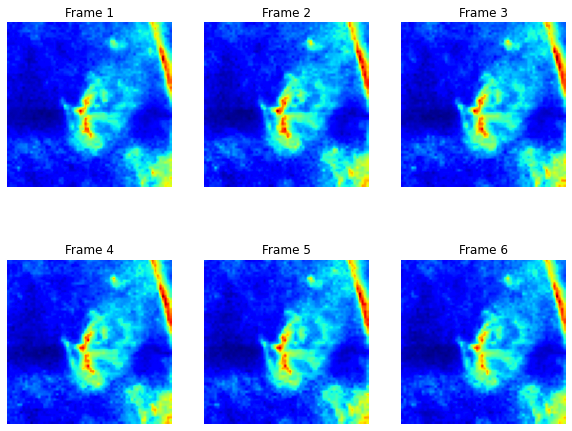

In [104]:
data_folder = './lstm_data/train/negative/AIA20180122_0237_0094'
paths = []
for subdir, dirs, files in os.walk(data_folder):
    for f in files:
        paths.append(os.path.join(subdir, f))
paths = sorted(paths)
for p in paths:
    print(p)

# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
# data_choice = np.random.choice(range(len(x_train)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(preprocessing.normalize(np.load(paths[idx]))), cmap='jet')
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
plt.show()